# Module 9 - Decision Trees

A Decision Tree (DT) is a type of classifier. The general motive of using Decision Tree is to create a training model which can be used to predict the class or value of target variables by learning decision rules inferred from prior data(training data).

A DT is a flowchart-like tree structure where an internal node represents a feature (or attribute), a branch represents a decision rule, and each leaf node represents the outcome. The top node is known as root node. 

How does a DT algorithm work?

1) Selects the best attribute using Attribute Selection Measures to split the records.
2) Makes that attribute a decision node. (Best attribute is placed as root node)
3) Splits the dataset into subsets. 
4) Repeat step 1-3 on each subset until it finds the leaf nodes in all branches of the tree. 

 
Advantages of DTs

  • Easy to understand by humans 
  • Supports classification and regression problems
  • Provides a graphical illustration - allows a comprehensive analysis of the consequences of each possible decision 
  • Results in a set of rules (if-then statements)
  
Disadvantages of DTs

  • High probability of overfitting
  • Calculations can become complex when there are many class labels
  • Biased with imbalanced datasets (recommended to balance out the dataset before creating the DT)
  


In [1]:
# Load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn import tree      # Import tree classifier 
from sklearn.model_selection import train_test_split     # Import train_test_split function
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score      # Import scikit-learn metrics module for accuracy calculation

In [2]:
# Load the Titanic dataset 

location = "datasets/titanic.xls"

df = pd.read_excel(location)
df.head()     # Get first five data rows

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Let's perform some exploratory analysis

In [3]:
# Get more information on the df dataframe including a list of all columns and their corresponding data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


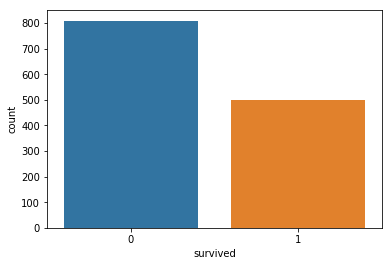

In [4]:
# Create a bar chart of survival status count
# dead=0, survived=1

sns.countplot(x='survived', data=df)

Approximately 62% of the passengers did not survive. 

### Clean the data

In [5]:
# Find columns that have missing values
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [7]:
# Fill missing values for age based on survival status, sex, and passenger class

df['age'].fillna(df.groupby(['survived', 'sex', 'pclass'])['age'].transform('mean'), inplace=True)

In [8]:
# Only 2 missing values so we'll fill with most common embarkation point
df['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [9]:
# Fill missing values
df['embarked'].fillna('S', inplace=True)

In [10]:
# Validate age and embarked no longer have missing values

df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        0
boat          823
body         1188
home.dest     564
dtype: int64

In [11]:
# Drop the variables that we don't want to include in our DT model

modeldf = df.drop(['name','ticket','fare', 'cabin', 'boat', 'body', 'home.dest'], axis=1)

In [12]:
# Columns left in our dataframe
modeldf.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'embarked'], dtype='object')

Create dummy variables for categorical values

Remember: a dummy variable takes the value 0 or 1 to indicate the absence or presence of some categorical effect that may be expected to shift the outcome. You have as many columns as you have values in the categorical variable. 

In [13]:
# Create dummy variables for passenger class and embarkation port
# get_dummies will auto-drop columns that dummies were created from
modeldf = pd.get_dummies(data=modeldf, columns=['pclass','embarked'])
modeldf.head()

,survived,sex,age,sibsp,parch,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,1,female,29.0000,0,0,1,0,0,0,0,1
1,1,male,0.9167,1,2,1,0,0,0,0,1
2,0,female,2.0000,1,2,1,0,0,0,0,1
3,0,male,30.0000,1,2,1,0,0,0,0,1
4,0,female,25.0000,1,2,1,0,0,0,0,1


In [14]:
# Change sex values to binary
# female=0, male=1

modeldf['sex'] = modeldf['sex'].map({'female':0, 'male':1})
modeldf.head()

,survived,sex,age,sibsp,parch,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,1,0,29.0000,0,0,1,0,0,0,0,1
1,1,1,0.9167,1,2,1,0,0,0,0,1
2,0,0,2.0000,1,2,1,0,0,0,0,1
3,0,1,30.0000,1,2,1,0,0,0,0,1
4,0,0,25.0000,1,2,1,0,0,0,0,1


In [15]:
# Create new column based on number of family members
# Drop sibsp and parch columns
modeldf['family_num'] = modeldf['sibsp'] + modeldf['parch']
modeldf.drop(['sibsp', 'parch'], axis=1, inplace=True)
modeldf.head()

,survived,sex,age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,family_num
0,1,0,29.0000,1,0,0,0,0,1,0
1,1,1,0.9167,1,0,0,0,0,1,3
2,0,0,2.0000,1,0,0,0,0,1,3
3,0,1,30.0000,1,0,0,0,0,1,3
4,0,0,25.0000,1,0,0,0,0,1,3


In [16]:
# Create a new column based on whether the passenger was traveling alone or not
# not traveling alone=0, traveling alone=1

modeldf['TravelAlone']=np.where((modeldf['family_num'] > 0), 0, 1)
modeldf.head()

,survived,sex,age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,family_num,TravelAlone
0,1,0,29.0000,1,0,0,0,0,1,0,1
1,1,1,0.9167,1,0,0,0,0,1,3,0
2,0,0,2.0000,1,0,0,0,0,1,3,0
3,0,1,30.0000,1,0,0,0,0,1,3,0
4,0,0,25.0000,1,0,0,0,0,1,3,0


### Build a Decision Tree

The goal of our model is to classify passengers of the Titanic into a group of survivors and non-survivors. 

In order to build our model, we first need to divide our columns into two types of variables - our target variable and predictor variables (or features).

In [17]:
# Let's extract our target variable
# Make a copy of 'survived' column

y = modeldf['survived']

In [18]:
# Make a copy of modeldf without 'survived' column

X = modeldf.drop(['survived'], axis=1)

Next, we need to split our data into training and test sets. This is a good strategy for understanding model performance. 

The training set is the data that we use to fit the model. The model sees and learns from this data. The test set is used to provide an unbiased evaluation of the model. It is only used once a model is completely trained. 

In [19]:
# 80% for training data, 20% for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

In [20]:
# Assign decision tree function to model variable
model = tree.DecisionTreeClassifier()

In [29]:
# Develop model using training data
# Defining arguments in the model can help prevent overfitting
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
# Run the predictions on the training data
y_predict_train = model.predict(X_train)

In [31]:
# Checks the accuracy of the training model
accuracy_score(y_train, y_predict_train)

0.9407831900668577

In [32]:
# Run the predictions on the test data
y_predict = model.predict(X_test)

In [33]:
#check the accuracy of model
accuracy_score(y_test, y_predict)

0.8091603053435115

In [34]:
#look at true and false predictions
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

,Predicted Not Survival,Predicted Survival
True Not Survival,147,20
True Survival,30,65


References:

http://dataaspirant.com/2017/01/30/how-decision-tree-algorithm-works/,
https://www.datacamp.com/community/tutorials/decision-tree-classification-python,
http://www.ijoart.org/docs/Construction-of-Decision-Tree--Attribute-Selection-Measures.pdf
